In [37]:
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats
import random
import datetime as dt
import os
%pylab inline
import geopandas as gd
import sys
import glob
import seaborn as sbn
import scipy.stats
import urllib
import shapely
import shapely
from pandas import DataFrame
import datetime
from shapely.geometry import Point
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt



Populating the interactive namespace from numpy and matplotlib


/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### First, install data.
- Locations of subway station from MTA website
- the number of passengers by stations
- Median rent for Studio, neighbourhood base in Zillow data
- Boundaries geometory data for Zillow data
- Crime map from NYPD

In [2]:
#Zillow
Zillow = pd.read_csv('http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_Studio.csv')

In [3]:
Zillow1 = Zillow[['RegionName','City','CountyName','2017-12']]
ind = Zillow1['City']=='New York'
Zillow2=Zillow1.loc[ind]
Zillow2.rename(columns={'RegionName': 'Name'},inplace=True)


/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
# Boundaries
urllib.request.urlretrieve("https://www.zillowstatic.com/static-neighborhood-boundaries/LATEST/static-neighborhood-boundaries/shp/ZillowNeighborhoods-NY.zip", "file.zip")
os.system("unzip " + "file.zip")

0

In [5]:
ls

file.zip          Scraper.ipynb               ZillowNeighborhoods-NY.shp
forGver2.csv      ZillowNeighborhoods-NY.dbf  ZillowNeighborhoods-NY.shx
PUIproject.ipynb  ZillowNeighborhoods-NY.prj


In [6]:
gd=gd.GeoDataFrame.from_file('ZillowNeighborhoods-NY.shp')

In [7]:
ind = gd['City']=='New York'
gdi=gd.loc[ind]
gdi.head()


,State,County,City,Name,RegionID,geometry
2,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...
5,NY,Queens,New York,Belle Harbor,10329,POLYGON ((-73.85618223699993 40.56810940300005...
10,NY,New York,New York,Roosevelt Island,20239,POLYGON ((-73.96143117599991 40.74851331600007...
13,NY,Queens,New York,Howard Beach,21970,POLYGON ((-73.85608525799972 40.65037135900031...
16,NY,Queens,New York,Breezy Point,37557,POLYGON ((-73.90962826099991 40.56552556300005...


In [8]:
ZillowMerge = gdi.merge(Zillow2, on='Name')
ZillowMerge.sort_values(['RegionID'])
print(len(ZillowMerge))
len(ZillowMerge.RegionID.unique())

67


64

Delete duplicated but slightly different rows. They are obviously wrong data. We should have three.

In [9]:
x = ZillowMerge.groupby('RegionID').count()
x.sort_values(['Name'],ascending=False).head()

,State,County,City_x,Name,geometry,City_y,CountyName,2017-12
RegionID,,,,,,,,
274627,2,2,2,2,2,2,2,2
403122,2,2,2,2,2,2,2,2
196538,2,2,2,2,2,2,2,2
10957,1,1,1,1,1,1,1,1
273860,1,1,1,1,1,1,1,1


In [10]:
ZillowMerge['x'] = ZillowMerge.centroid.x
ZillowMerge['y'] = ZillowMerge.centroid.y

In [11]:
ZillowMerge.head(1)

,State,County,City_x,Name,RegionID,geometry,City_y,CountyName,2017-12,x,y
0,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...,New York,Queens County,1695.0,-73.861493,40.726023


In [12]:
len(ZillowMerge)

67

In [13]:
ZillowMerge['x'] = ZillowMerge['x'].astype(str)
ZillowMerge['y'] = ZillowMerge['y'].astype(str)
ZillowMerge.dtypes

State          object
County         object
City_x         object
Name           object
RegionID       object
geometry       object
City_y         object
CountyName     object
2017-12       float64
x              object
y              object
dtype: object

In [14]:
ZillowMerge['forG'] = ZillowMerge.y + ',' + ZillowMerge.x

Now, we got 'forG' which is LonLat for google map scraper, and pass it as csv. I will change notebook here because my environment in ADRF doesn't arrow me to use selenium. Do it locally.

In [15]:
ZillowMerge.to_csv("forG.csv",index=False,encoding="utf8")

Then, we got forGver2, which contains data scraped from google map.

In [16]:
ZillowG = pd.read_csv('forGver2.csv',encoding="utf8")
ZillowG.head(1)

,TimesSquare,NYSE,State,County,City_x,Name,RegionID,geometry,City_y,CountyName,2017-12,x,y,forG
0,36 min,48 min,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...,New York,Queens County,1695.0,-73.861493,40.726023,"40.726023100096064,-73.86149262806855"


Need some data cleaning for TimesSquare and NYSE. Delete min and h, and convert h to 60.

In [17]:
TSt = []
for i in range(len(ZillowG)):
    try:
        ac = int(ZillowG.TimesSquare.iloc[i].strip('min').split('h')[0])*60 + int(ZillowG.TimesSquare.iloc[i].strip('min').split('h')[1])
    except AttributeError:
        ac = 0
    except:
        ac = int(ZillowG.TimesSquare.iloc[i].strip('min').split('h')[0])
    TSt.append(ac)

In [18]:
NYt = []
for i in range(len(ZillowG)):
    try:
        ac = int(ZillowG.NYSE.iloc[i].strip('min').split('h')[0])*60 + int(ZillowG.NYSE.iloc[i].strip('min').split('h')[1])
    except ValueError:
        ac = int(ZillowG.NYSE.iloc[10].strip('min').split('h')[0])*60
    except AttributeError:
        ac = 0
    except:
        ac = int(ZillowG.NYSE.iloc[i].strip('min').split('h')[0])
    NYt.append(ac)

In [19]:
ZillowG['TSt'] = TSt
ZillowG['NYt'] = NYt

index 23 24 52 should be deleted

In [20]:
ZillowMerge.drop([23,24,52],inplace=True)

In [21]:
len(ZillowMerge)
len(ZillowG)

64

In [22]:
ZillowMerge.reset_index(drop=True,inplace=True)

In [23]:
ZillowMergeG = pd.concat([ZillowMerge,ZillowG['TSt'],ZillowG['NYt']],axis=1)

(-74.137948952172, -73.72518193380131, 40.55602215771792, 40.9110231179247)

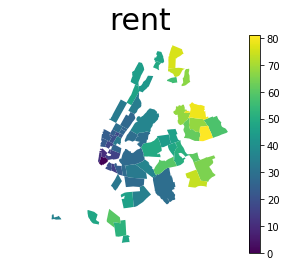

In [24]:
fig = pl.figure(figsize=(20,4))
ax1 = fig.add_subplot(141)
ax1.set_title('rent', fontsize=30)
ZillowMergeG.plot(column='NYt', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')


Then, get crime map

In [25]:
#urllib.request.urlretrieve("https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD", "crime.csv")
urllib.request.urlretrieve("https://data.cityofnewyork.us/resource/9s4h-37hy.csv?$where=cmplnt_to_dt%20%3E%20%272016-1-1T00:00:00.000%27&$limit=10000000", "crime.csv")


('crime.csv', <http.client.HTTPMessage at 0x7f6bf8259518>)

In [32]:
cr = pd.read_csv('crime.csv')

In [33]:
cr.shape

(787359, 39)

In [34]:
cr = cr[(cr['law_cat_cd']=='FELONY')]

In [35]:
cr.head()

,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_num,cmplnt_to_dt,cmplnt_to_tm,crm_atpt_cptd_cd,hadevelopt,housing_psa,...,station_name,susp_age_group,susp_race,susp_sex,transit_district,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd
2,42,BRONX,2016-01-02T00:00:00.000,18:40:00,235722347,2016-01-02T00:00:00.000,18:46:00,COMPLETED,NaN,NaN,...,NaN,45-64,BLACK HISPANIC,M,NaN,UNKNOWN,UNKNOWN,E,1008690.0,238862.0
4,115,QUEENS,2016-01-02T00:00:00.000,21:00:00,498664004,2016-01-02T00:00:00.000,21:21:00,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK HISPANIC,M,NaN,UNKNOWN,UNKNOWN,E,1019543.0,213692.0
16,14,MANHATTAN,2016-01-01T00:00:00.000,21:10:00,574783966,2016-01-02T00:00:00.000,10:30:00,COMPLETED,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE,F,986616.0,216180.0
18,107,QUEENS,2016-01-01T00:00:00.000,21:30:00,808243061,2016-01-02T00:00:00.000,12:15:00,COMPLETED,NaN,NaN,...,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,ASIAN / PACIFIC ISLANDER,M,1036162.0,203942.0
23,26,MANHATTAN,2015-12-31T00:00:00.000,19:00:00,515923882,2016-01-02T00:00:00.000,15:35:00,COMPLETED,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,45-64,BLACK,M,998312.0,236106.0


In [38]:
cr.dropna(subset=['longitude'],inplace=True)
cr.dropna(subset=['latitude'],inplace=True)

cr['lonlat']=list(zip(cr.longitude,cr.latitude))
cr['geometry']=cr[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

crs = {'init': 'epsg:4326'}
cr1 =gd.GeoDataFrame(cr, crs=crs, geometry=cr['geometry'])
cr1.shape

(248211, 41)

In [39]:
cr2 = cr1[['geometry','cmplnt_fr_dt']]

In [40]:
type(ZillowMergeG)

geopandas.geodataframe.GeoDataFrame

In [41]:
crs = {'init': 'epsg:4326'}
ZillowMG =gd.GeoDataFrame(ZillowMergeG, crs=crs, geometry=ZillowMergeG['geometry'])
ZillowMG.shape

(64, 14)

In [42]:
cr2['count'] = 1
cr2.head()

/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,geometry,cmplnt_fr_dt,count
2,POINT (-73.91169778 40.822271041),2016-01-02T00:00:00.000,1
4,POINT (-73.872617314 40.7531495),2016-01-02T00:00:00.000,1
16,POINT (-73.99146089 40.760048541),2016-01-01T00:00:00.000,1
18,POINT (-73.812709228 40.726306278),2016-01-01T00:00:00.000,1
23,POINT (-73.949200086 40.814729212),2015-12-31T00:00:00.000,1


In [43]:
ZillowGc = gd.sjoin(ZillowMG,cr2)


In [44]:
count = ZillowGc.groupby('RegionID').count()

In [45]:
ZillowMGc = ZillowMG.merge(count[['count']], on='RegionID')
crs = {'init': 'epsg:4326'}
ZillowMGc =gd.GeoDataFrame(ZillowMGc, crs=crs, geometry=ZillowMGc['geometry'])


In [46]:
type(ZillowMGc)

geopandas.geodataframe.GeoDataFrame

In [47]:
df = ZillowMGc[['RegionID','Name','2017-12','TSt','NYt','count','geometry']]
df.rename(columns={'2017-12': 'rent', 'count':'felony', 'TSt':'To_TSquare',
                   'NYt':'To_NYSE'},inplace=True)
df.head()

,RegionID,Name,rent,To_TSquare,To_NYSE,felony,geometry
0,6719,Rego Park,1695.0,36,48,566,POLYGON ((-73.85629999999999 40.72303000000012...
1,5837,Maspeth,1875.0,52,49,1136,"POLYGON ((-73.8881191182047 40.73555656190326,..."
2,8731,Fort Hamilton,1437.5,64,48,511,POLYGON ((-74.02362999999993 40.61995000000007...
3,25294,Jamaica,1600.0,63,65,4825,POLYGON ((-73.77147645488819 40.71185413791184...
4,27182,South Ozone Park,2000.0,65,74,1947,POLYGON ((-73.81073992748637 40.69114001943669...


In [48]:
df.mean()

RegionID              inf
rent          2179.273438
To_TSquare      38.625000
To_NYSE         39.828125
felony        2174.343750
dtype: float64

Plot them

(-74.13794895217201, -73.72518193380132, 40.556022157717926, 40.91102311792471)

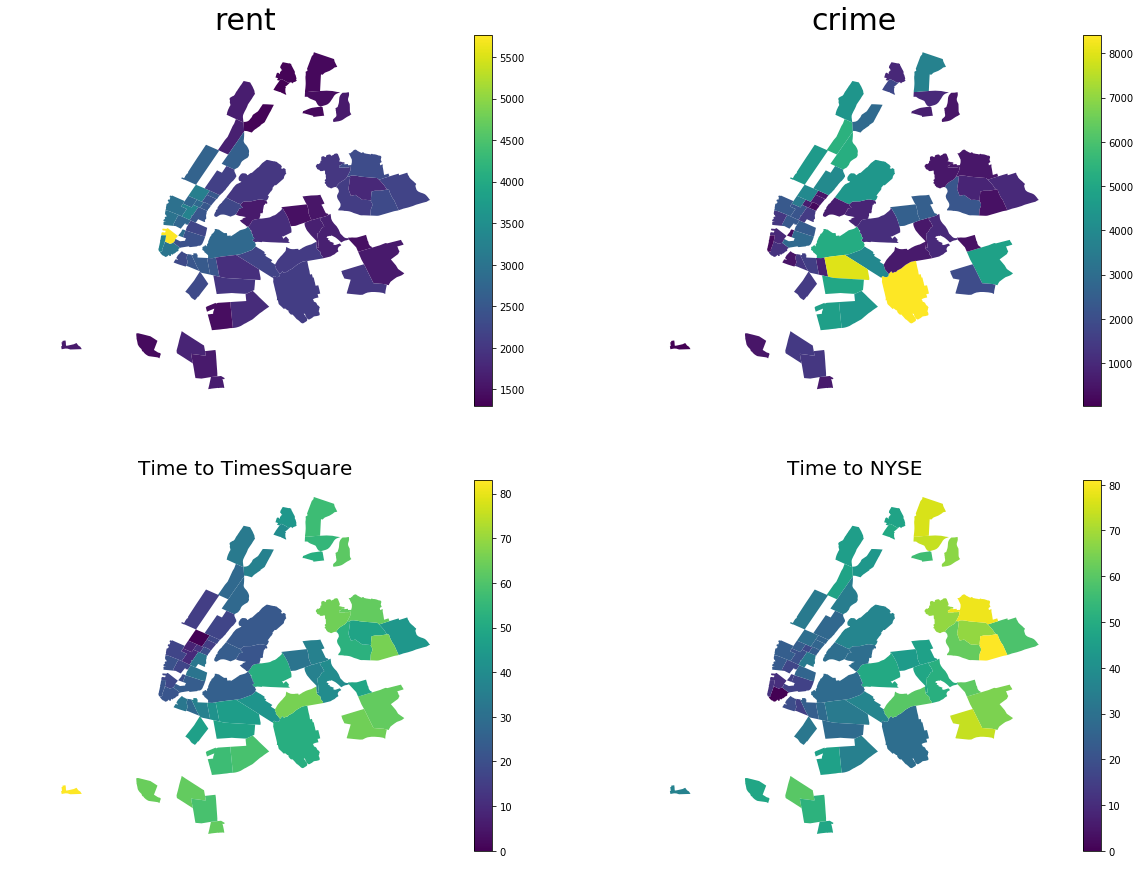

In [49]:
fig = pl.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax1.set_title('rent', fontsize=30)
df.plot(column='rent', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')

ax1 = fig.add_subplot(222)
ax1.set_title('crime', fontsize=30)
df.plot(column='felony', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')

ax1 = fig.add_subplot(223)
ax1.set_title('Time to TimesSquare', fontsize=20)
df.plot(column='To_TSquare', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')

ax1 = fig.add_subplot(224)
ax1.set_title('Time to NYSE', fontsize=20)
df.plot(column='To_NYSE', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')


Now we got all the data and finished cleaning.

In [50]:
dfT = df[['rent','felony','To_TSquare']]
dfN = df[['rent','felony','To_NYSE']]

Outliers Detection. We have two patterns; From TimesSquare and NYSE.

In [51]:
clf = LocalOutlierFactor(n_neighbors=5)
pred = clf.fit_predict(dfT)
outliersT = np.where(pred < 0)
outliersT

/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([13, 16, 23, 32, 35, 37, 41]),)

In [52]:
clf = LocalOutlierFactor(n_neighbors=5)
pred = clf.fit_predict(dfN)
outliersN = np.where(pred < 0)
outliersN

/nfshome/ku373/.conda/envs/env_ver3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([13, 16, 23, 32, 35, 37, 41]),)

In [53]:
dfoutliers = df.loc[outliersT]
dfoutliers

,RegionID,Name,rent,To_TSquare,To_NYSE,felony,geometry
13,194430,East New York,2100.0,52,29,8405,"POLYGON ((-73.86650399999961 40.6844740000005,..."
16,198296,Sunnyside,1600.0,83,36,29,POLYGON ((-74.11423530022616 40.61426415124382...
23,274627,Murray Hill,2800.0,12,18,696,POLYGON ((-73.97682910740397 40.74748235082775...
32,270951,Tribeca,5760.0,18,11,978,POLYGON ((-74.00857077099994 40.71139572600003...
35,272869,Battery Park,3250.0,22,12,235,POLYGON ((-74.01671379899994 40.71956434200007...
37,272902,Bedford Stuyvesant,1895.0,46,33,7997,POLYGON ((-73.92459322999997 40.69091087200007...
41,270873,Little Italy,2890.0,20,15,342,POLYGON ((-73.99274316325516 40.72425969387396...


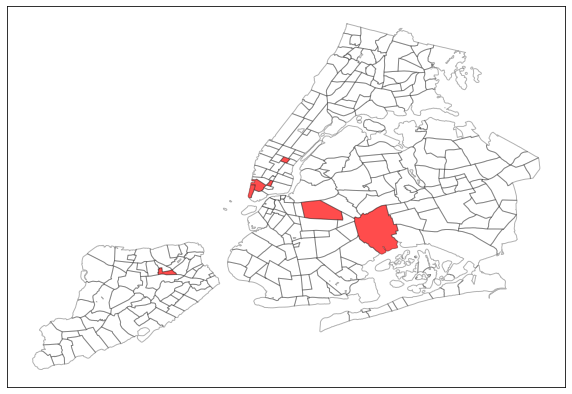

In [54]:
'''fig = pl.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax1.set_title('rent', fontsize=30)
dfoutliers.plot(ax=ax1, legend=True)
ax1.axis('off')

ax1 = fig.add_subplot(222)
ax1.set_title('crime', fontsize=30)
df.plot(column='felony', cmap='viridis', ax=ax1, legend=True)
ax1.axis('off')
'''


f, ax = plt.subplots(figsize=(10,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
dfoutliers.plot(color = 'r', ax=ax)
gdi.plot(color="white", edgecolor="black", lw=1,column=None, ax=ax, alpha = 0.3)

#plt.title("Outlier areas in terms of rent, felony counts, and commuting time");


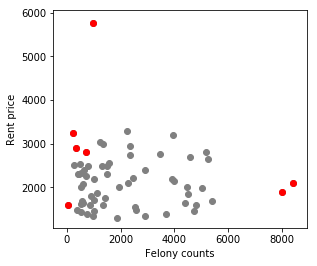

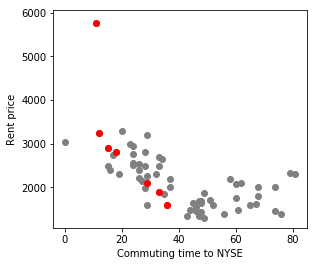

In [55]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(df['felony'], df['rent'], c='gray')
plt.xlabel('Felony counts')
plt.ylabel('Rent price')


plt.scatter(dfoutliers['felony'], dfoutliers['rent'], c='red')
#plt.title("Kmeans-{} clusters")
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
plt.scatter(df['To_NYSE'], df['rent'], c='gray')
plt.xlabel('Commuting time to NYSE')
plt.ylabel('Rent price')


plt.scatter(dfoutliers['To_NYSE'], dfoutliers['rent'], c='red')
#plt.title("Kmeans-{} clusters")
plt.show()


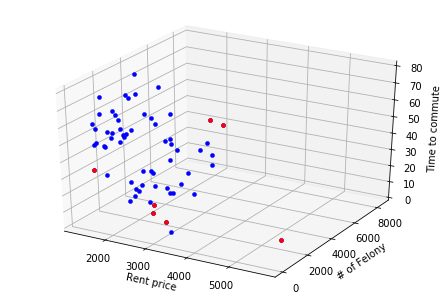

In [61]:

fig = pyplot.figure()
ax = Axes3D(fig)

ax.set_xlabel("Rent price")
ax.set_ylabel("# of Felony")
ax.set_zlabel("Time to commute")

ax.plot(df['rent'], df['felony'], df['To_NYSE'], "o", color="b", ms=4, mew=0.5)
ax.plot(df['rent'].loc[outliersT], df['felony'].loc[outliersT], df['To_NYSE'].loc[outliersT], "o", color="r", ms=4, mew=0.5)

#([13, 16, 23, 32, 35, 37, 41])

pyplot.show()

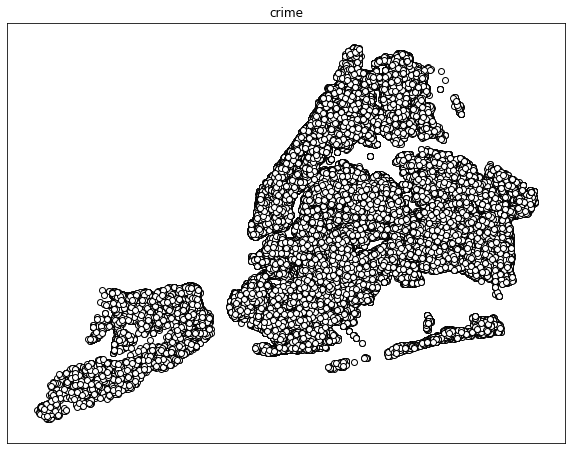

In [62]:
ax = cr1.plot(figsize=(10,10),color="white", edgecolor="black", lw=1,column=None)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("crime");
